In [1]:
import tensorflow as tf
import pandas as pd

tf.compat.v1.disable_v2_behavior()

import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from scipy import signal
import openpyxl
import seaborn as sns
from keijzer import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


C:\Users\Smartgrid_ML\Documents\KMS\btm_data\Korean_Solar\Final\03_Error Learning\keijzer.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Saving heatmap


<Figure size 432x288 with 0 Axes>

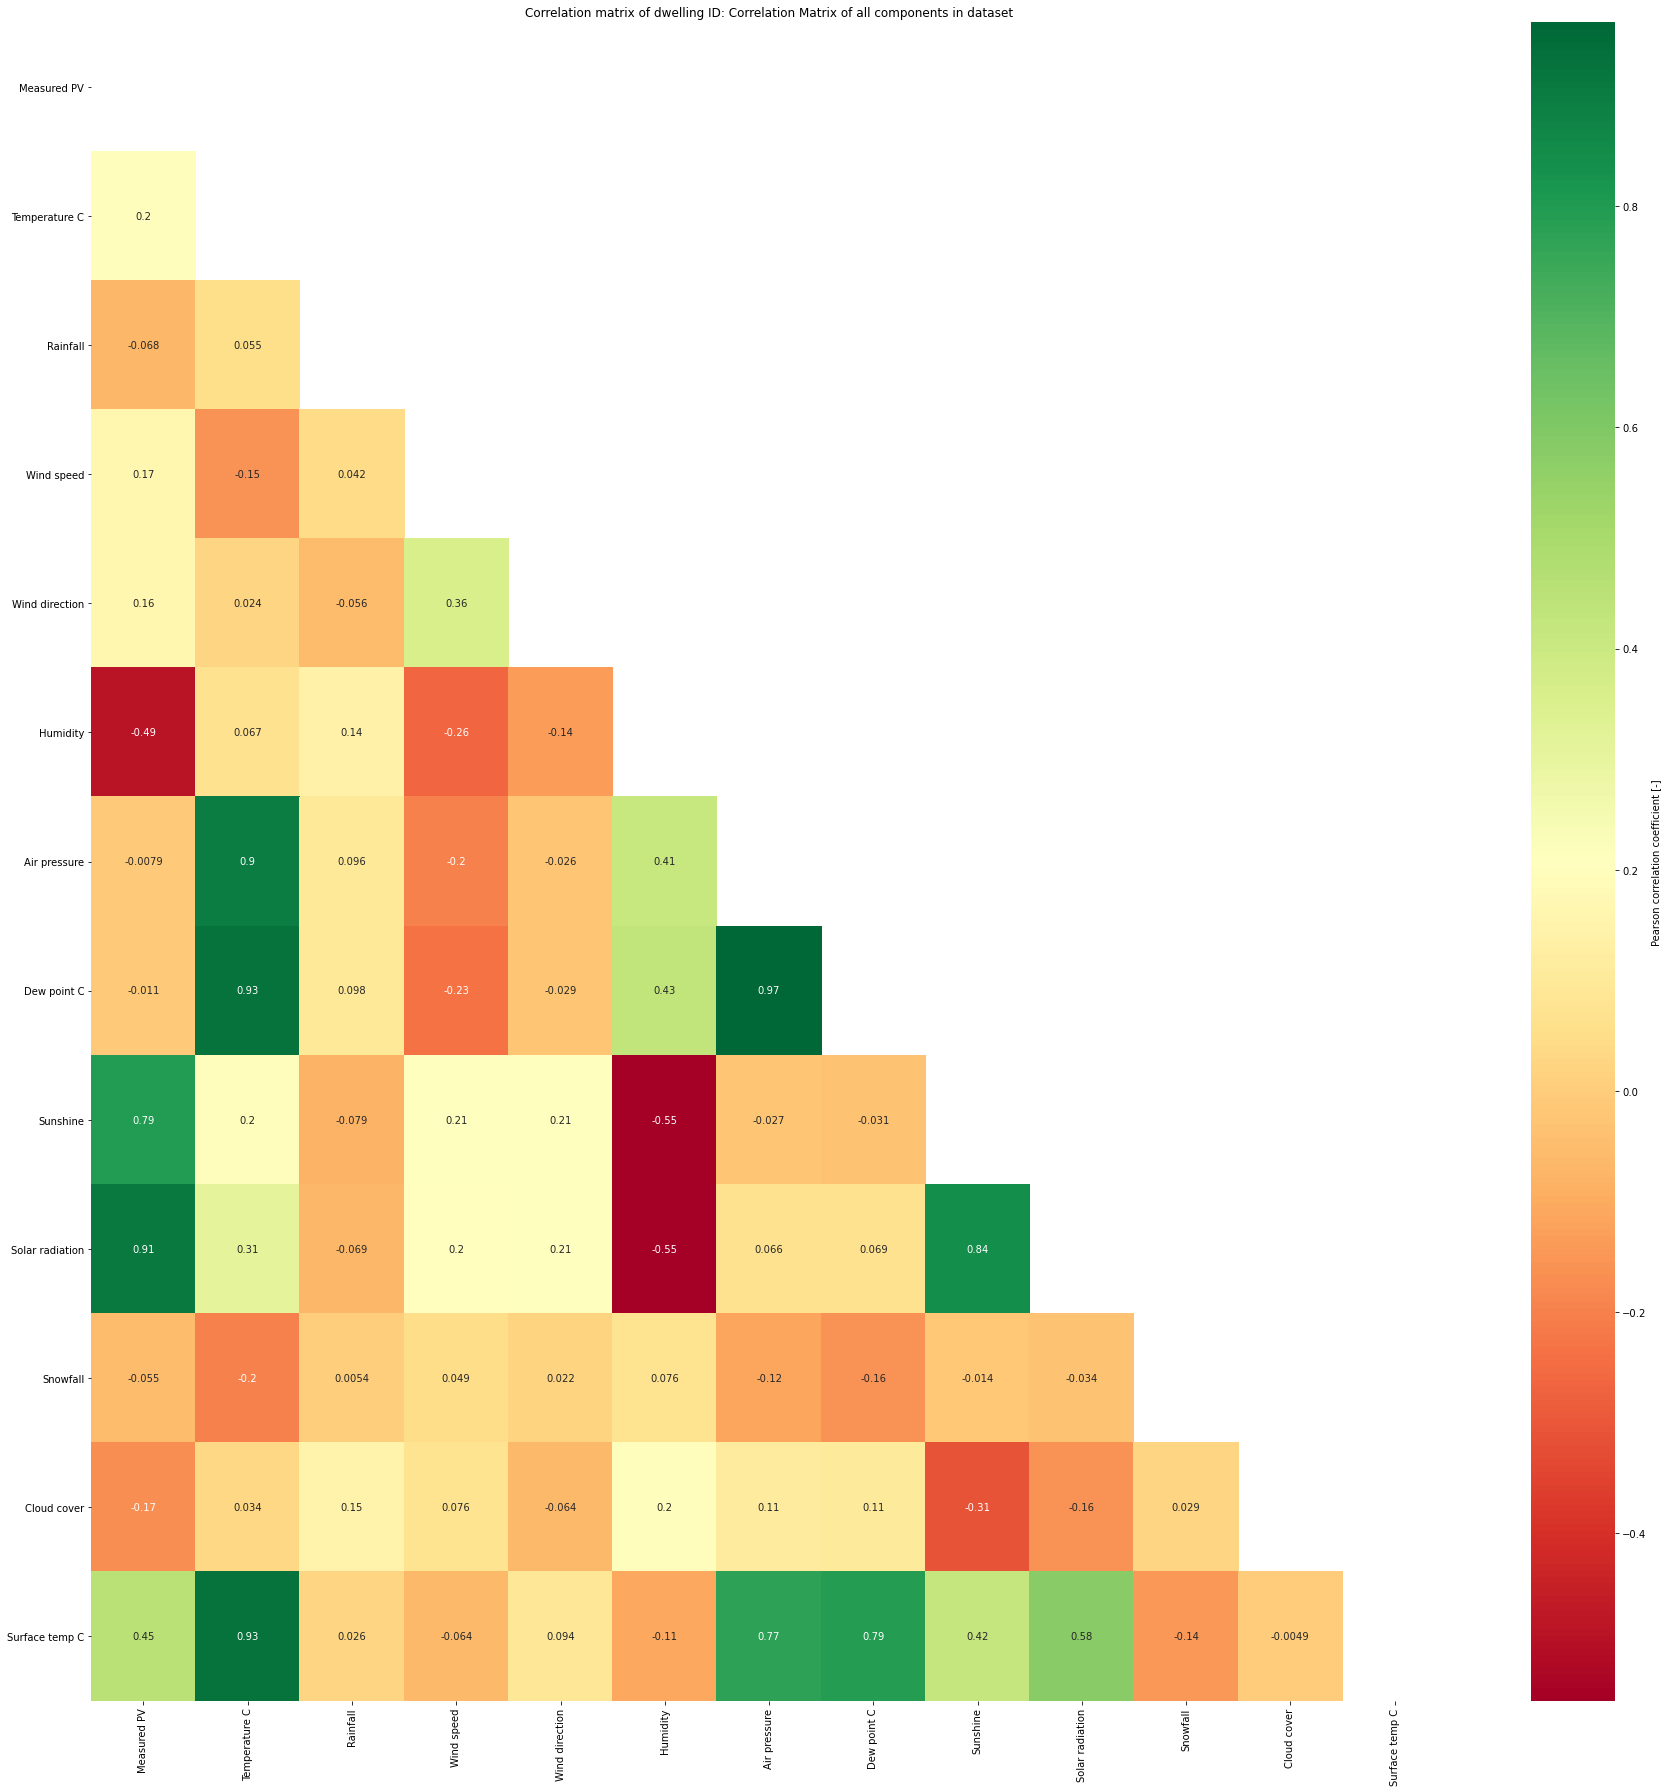

In [3]:
import seaborn as sns
from keijzer import *

fig = create_corr_matrix(norm_df, 'Correlation Matrix of all components in dataset', True, size=(25,25))
fig.savefig('correlation_matrix.png')

In [4]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 4, 5, 6, 8, 9, 11, 12)]

In [5]:
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [6]:
timesteps = 30
output_timesteps = 12

X, Y = create_dataset(norm_df2, timesteps, output_timesteps)

trX = X[:18389, :, :]
vaX = X[18389:21447, :, :]
teX = X[21447:, :, :]
trY = Y[:18389, :, 0]
vaY = Y[18389:21447, :, 0]
teY = Y[21447:, :, 0]

print(trX.shape)
print(trY.shape)
print(teX.shape)

(18389, 30, 9)
(18389, 12)
(9158, 30, 9)


In [7]:
with tf.device('/gpu:0'):
    alpha=1.05
    gamma=1.2
    beta = 1.15011
    num_features = 9
    hfilters = 256
    hkernel_size1 = 2
    hkernel_size2 = 4
    visible1 = Input(shape=(timesteps, num_features))
    per1 = Permute((2,1))(visible1)
    den1a = Dense(timesteps, activation='tanh')(per1)
    den1b = Dense(timesteps, activation='sigmoid')(per1)
    den1 = Multiply()([den1a, den1b])
    per2 = Permute((2,1), name='attention_vec')(den1)
    mul1 = Multiply()([visible1, per2])
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    
    res10 = Add()([d1, res09])   # 
    
    print('res10 :', res10.shape)  # (None, 24, 11) 
    
    out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
    out = Dropout(0.2)(out)   
    
    out = Conv1D(256, 1, padding='same', activation='relu')(out) # 512,  110X5=550
    out = Dropout(0.2)(out)  
    
    out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1
    
    out = Dense(output_timesteps)(out) 
    model = Model(inputs=[visible1], outputs=[out])
    
    print(model.summary())
    
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()
    
    #hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

res10 : (?, 30, 9)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 9)]      0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 9, 30)        0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 9, 30)        930         permute[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 9, 30)        930         permute[0][0]                    
___________________________________________________________________________

In [8]:
    %%time
    hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

Train on 18389 samples, validate on 3058 samples
Epoch 1/1000
18389/18389 [==============================] - ETA: 0s - loss: 0.1654 - root_mean_squared_error: 0.1654 - mean_squared_error: 0.0298 - mean_absolute_error: 0.1198

C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


18389/18389 [==============================] - 9s 512us/sample - loss: 0.1654 - root_mean_squared_error: 0.1654 - mean_squared_error: 0.0298 - mean_absolute_error: 0.1198 - val_loss: 0.1519 - val_root_mean_squared_error: 0.1519 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1003
Epoch 2/1000
18389/18389 [==============================] - 6s 323us/sample - loss: 0.1323 - root_mean_squared_error: 0.1323 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0857 - val_loss: 0.1525 - val_root_mean_squared_error: 0.1526 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.0964
Epoch 3/1000
18389/18389 [==============================] - 6s 328us/sample - loss: 0.1265 - root_mean_squared_error: 0.1265 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0804 - val_loss: 0.1506 - val_root_mean_squared_error: 0.1508 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.0955
Epoch 4/1000
18389/18389 [==============================] - 6s 320us/sample - loss: 0.121

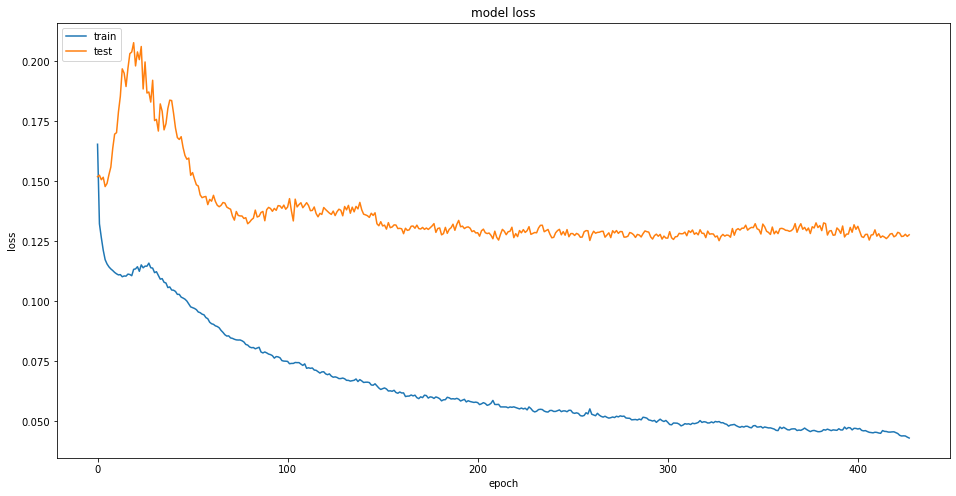

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('PV_Tl24h_TrainingandValidation Loss.png')
plt.show()

#print(get_flops(model))

In [10]:
trainPredict = model.predict(trX, batch_size=batch_size)
validPredict = model.predict(vaX, batch_size=batch_size)
testPredict = model.predict(teX, batch_size=batch_size)

In [11]:
tePredict = testPredict.reshape([-1])
testY = teY.reshape([-1])

np.savetxt('PV_Tl24h_testPredict.txt', tePredict)
 
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(testY-tePredict))), ' MAE == ', mean_absolute_error(testY, tePredict))

Error Test Score > RMSE ==  0.11576411980517975  MAE ==  0.062498346197711975


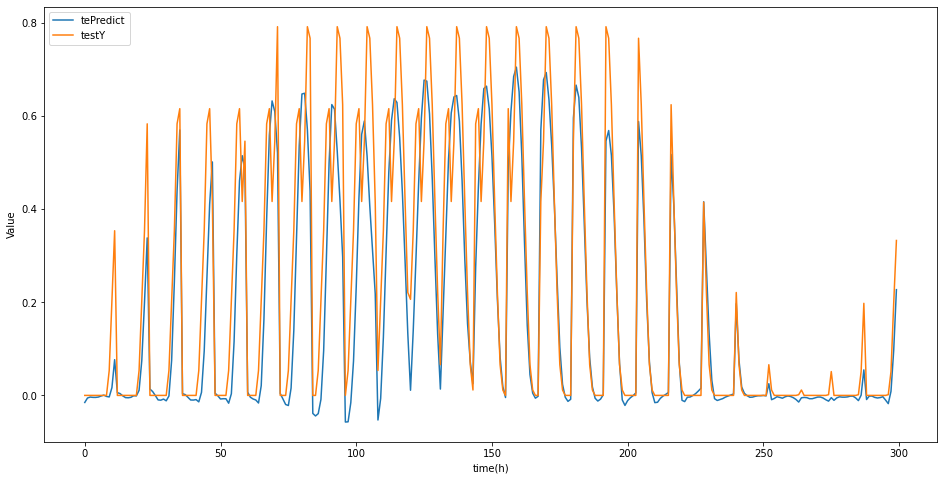

In [12]:
plt.figure(figsize=(16,8)) 
plt.plot(tePredict[0:300])
plt.plot(testY[0:300])
plt.ylabel('Value')
plt.xlabel('time(h)')
plt.legend(['tePredict', 'testY'], loc='upper left')
plt.show()

In [13]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21447, 12)
(21447, 12)


In [14]:
dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df2 = norm_df.iloc[:21447, :].copy()
norm_df2.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [15]:
norm_df2 = norm_df2.iloc[:,[0, 4, 5, 6, 8, 11, 12]]
norm_df2.head()

,Measured PV,Wind direction,Humidity,Air pressure,Sunshine,Cloud cover,Surface temp C
0,0.0,0.000000,0.89,0.189696,0.0,0.6,0.141834
1,0.0,0.444444,0.93,0.189696,0.0,0.0,0.117479
2,0.0,0.388889,0.93,0.177986,0.0,0.0,0.103152
3,0.0,0.444444,0.94,0.170960,0.0,0.0,0.095989
4,0.0,0.444444,0.95,0.161593,0.0,0.0,0.088825


In [16]:
Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12']

pr_df = pd.DataFrame(prediction, columns=Prindex)
pr_df.head()

,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9,Prediction10,Prediction11,Prediction12
0,-0.013284,-0.020057,0.060027,0.258359,0.464299,0.578825,0.595944,0.551129,0.439513,0.269017,0.088880,-0.032440
1,-0.016248,0.050899,0.217783,0.450588,0.610713,0.652465,0.611209,0.507364,0.329479,0.142465,0.020306,-0.024891
2,0.084551,0.272766,0.488188,0.644415,0.683012,0.624947,0.480671,0.271436,0.083838,-0.010596,-0.017925,-0.002797
3,0.200838,0.411339,0.603175,0.701646,0.666311,0.526965,0.327646,0.129232,0.008573,-0.026502,-0.014553,0.001120
4,0.459435,0.594407,0.645291,0.603068,0.486245,0.312227,0.133436,0.013599,-0.018086,-0.013932,-0.009739,-0.002540


In [17]:
er_df = pd.DataFrame(errors, columns=Erindex)
er_df.head()

,Error1,Error2,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,-0.013284,-0.020057,0.032120,0.100994,-0.037251,-0.013423,-0.076924,-0.037243,-0.073665,-0.095324,-0.039027,-0.038642
1,-0.016248,0.022992,0.060419,-0.050962,0.018465,-0.020403,0.022837,-0.005814,-0.034862,0.014558,0.014104,-0.024891
2,0.056644,0.115402,-0.013362,0.052167,0.010144,0.036575,-0.032508,-0.092905,-0.044069,-0.016797,-0.017925,-0.002797
3,0.043474,-0.090211,0.010927,0.028778,0.077939,0.013787,-0.036695,0.001325,0.002371,-0.026502,-0.014553,0.001120
4,-0.042115,0.002159,-0.027577,0.014696,-0.026933,-0.052114,0.005529,0.007397,-0.018086,-0.013932,-0.009739,-0.002540


In [18]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2.head()

,Measured PV,Wind direction,Humidity,Air pressure,Sunshine,Cloud cover,Surface temp C,Prediction1,Prediction2,Prediction3,...,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.0,0.000000,0.89,0.189696,0.0,0.6,0.141834,-0.013284,-0.020057,0.060027,...,0.032120,0.100994,-0.037251,-0.013423,-0.076924,-0.037243,-0.073665,-0.095324,-0.039027,-0.038642
1,0.0,0.444444,0.93,0.189696,0.0,0.0,0.117479,-0.016248,0.050899,0.217783,...,0.060419,-0.050962,0.018465,-0.020403,0.022837,-0.005814,-0.034862,0.014558,0.014104,-0.024891
2,0.0,0.388889,0.93,0.177986,0.0,0.0,0.103152,0.084551,0.272766,0.488188,...,-0.013362,0.052167,0.010144,0.036575,-0.032508,-0.092905,-0.044069,-0.016797,-0.017925,-0.002797
3,0.0,0.444444,0.94,0.170960,0.0,0.0,0.095989,0.200838,0.411339,0.603175,...,0.010927,0.028778,0.077939,0.013787,-0.036695,0.001325,0.002371,-0.026502,-0.014553,0.001120
4,0.0,0.444444,0.95,0.161593,0.0,0.0,0.088825,0.459435,0.594407,0.645291,...,-0.027577,0.014696,-0.026933,-0.052114,0.005529,0.007397,-0.018086,-0.013932,-0.009739,-0.002540


In [19]:
norm_df2 = np.array(norm_df2)
print(norm_df2.shape)
timesteps = 30
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
print(Xe.shape)
print(Ye.shape)

(21447, 31)
(21415, 30, 31)
(21415, 1, 31)


In [20]:
trXe = Xe[:19000, :, :]
vaXe = Xe[19000:, :, :]
trYe = Ye[:19000, :, -12:]
vaYe = Ye[19000:, :, -12:]
trYe = trYe.reshape(-1,12)
vaYe = vaYe.reshape(-1,12)
print(trXe.shape)
print(trYe.shape)
print(vaXe.shape)

(19000, 30, 31)
(19000, 12)
(2415, 30, 31)


In [21]:
with tf.device('/gpu:0'):
    def make_model(alpha):
        beta = math.sqrt(2/alpha/1.44)
        hfilters = 128
        hkernel_size1 = 2
        hkernel_size2 = 4
        num_features = 31
        visible1e = Input(shape=(timesteps, num_features))
        per1 = Permute((2,1))(visible1e)
        den1a = Dense(timesteps, activation='tanh')(per1)
        den1b = Dense(timesteps, activation='sigmoid')(per1)
        den1 = Multiply()([den1a, den1b])
        per2 = Permute((2,1), name='attention_vece')(den1)
        mul1 = Multiply()([visible1e, per2])
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res01 = Add()([d1, visible1e])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res02 = Add()([d1, res01])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res03 = Add()([d1, res02])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res04 =Add()([d1, res03])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res05 = Add()([d1, res04])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res06 = Add()([d1, res05])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res07 = Add()([d1, res06])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res08 = Add()([d1, res07])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res09 = Add()([d1, res08])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])

        res10 = Add()([d1, res09])   # 

        print('res10 :', res10.shape)  # (None, 24, 11) 

        oute = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
        oute = Dropout(0.2)(oute)   

        oute = Conv1D(256, 1, padding='same', activation='relu')(oute) # 512,  110X5=550
        oute = Dropout(0.2)(oute)  

        oute = GlobalAveragePooling1D()(oute) # pool_size=2, strides=1

        oute = Dense(12)(oute) 
        modele = Model(inputs=[visible1e], outputs=[oute])
        modele.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'accuracy'])
        return modele
    
    alpha_cand = [1.0, 1.05, 1.1, 1.2]
    
    my_classifier = KerasClassifier(make_model, batch_size = 100)
    validator = GridSearchCV(my_classifier, param_grid = {'alpha': alpha_cand, 'epochs' : [200]})
    
    validator.fit(trXe, trYe, verbose=2)
    
    print('The parameters of the best model are: ')
    print(validator.best_params_)

res10 : (?, 30, 31)
Train on 15200 samples
Epoch 1/200
15200/15200 - 5s - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 853.3911 - acc: 0.0970
Epoch 2/200
15200/15200 - 4s - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 741.4314 - acc: 0.1308
Epoch 3/200
15200/15200 - 4s - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 702.9944 - acc: 0.1516
Epoch 4/200
15200/15200 - 4s - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 579.9412 - acc: 0.1829
Epoch 5/200
15200/15200 - 4s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 610.1630 - acc: 0.2522
Epoch 6/200
15200/15200 - 4s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0234 - mean_absolute_percentage_error: 668.4537 - acc: 0.30

C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


res10 : (?, 30, 31)
Train on 15200 samples
Epoch 1/200
15200/15200 - 5s - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 927.1000 - acc: 0.0922
Epoch 2/200
15200/15200 - 4s - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 678.9135 - acc: 0.1184
Epoch 3/200
15200/15200 - 4s - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 550.3890 - acc: 0.1421
Epoch 4/200
15200/15200 - 4s - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0243 - mean_absolute_percentage_error: 606.2983 - acc: 0.1662
Epoch 5/200
15200/15200 - 4s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0235 - mean_absolute_percentage_error: 515.4250 - acc: 0.1978
Epoch 6/200
15200/15200 - 4s - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0226 - mean_absolute_percentage_error: 566.3287 - acc: 0.24